In [1]:
import zipfile

# Path to the .zip file
zip_file_path = r'C:\Users\Aryan Gupta\Desktop\Vedamrut\nails_dataset.zip'

# Destination folder where the dataset will be extracted
dataset_extracted_path = r'C:\Users\Aryan Gupta\Desktop\Vedamrut\nails_dataset_extracted'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_extracted_path)

print(f"Dataset extracted to: {dataset_extracted_path}")

Dataset extracted to: C:\Users\Aryan Gupta\Desktop\Vedamrut\nails_dataset_extracted


In [2]:
import os

# Define the paths for the extracted dataset
train_dir = os.path.join(dataset_extracted_path, 'data', 'train')  # Training data path
validation_dir = os.path.join(dataset_extracted_path, 'data', 'validation')  # Validation data path

# Verify the folders
print("Train folders:", os.listdir(train_dir))
print("Validation folders:", os.listdir(validation_dir))

Train folders: ['Acral_Lentiginous_Melanoma', 'blue_finger', 'clubbing', 'Healthy_Nail', 'Onychogryphosis', 'pitting']
Validation folders: ['Acral_Lentiginous_Melanoma', 'blue_finger', 'clubbing', 'Healthy_Nail', 'Onychogryphosis', 'pitting']


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load validation data
validation_data = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Print class indices
print("Class Indices:", train_data.class_indices)

# Print the class labels and their indices
print("Class Labels:", train_data.class_indices)
print("Number of training samples:", len(train_data))
print("Number of classes:", len(train_data.class_indices))

Found 3744 images belonging to 6 classes.
Found 91 images belonging to 6 classes.
Class Indices: {'Acral_Lentiginous_Melanoma': 0, 'Healthy_Nail': 1, 'Onychogryphosis': 2, 'blue_finger': 3, 'clubbing': 4, 'pitting': 5}
Class Labels: {'Acral_Lentiginous_Melanoma': 0, 'Healthy_Nail': 1, 'Onychogryphosis': 2, 'blue_finger': 3, 'clubbing': 4, 'pitting': 5}
Number of training samples: 59
Number of classes: 6


Build the CNN Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Load the MobileNetV2 pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze the base model to use pre-trained weights

# Build the full model
model = Sequential([
    base_model,  # Pre-trained base
    GlobalAveragePooling2D(),  # Replace flattening layers with pooling
    Dense(128, activation='relu'),  # Add a dense layer for custom classification
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')  # Output layer for classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Callbacks for training
callbacks = [
    ModelCheckpoint(
        'best_model_mobilenet.keras',  # Save the best model
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )
]

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the Model

In [25]:
# Train the model
EPOCHS = 20  # Keep it at 20 since pre-trained models usually converge faster

# Add callbacks (already defined in Cell 4)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Add ReduceLROnPlateau for dynamic learning rate adjustment
callbacks = [
    ModelCheckpoint(
        'best_model_mobilenet.keras',  # Save the best version of the model
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6  # Minimum learning rate
    )
]

# Train the model using the pre-trained MobileNetV2
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2319 - loss: 2.0419 - val_accuracy: 0.6374 - val_loss: 1.1882 - learning_rate: 1.0000e-04
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4537 - loss: 1.3578 - val_accuracy: 0.7143 - val_loss: 0.9303 - learning_rate: 1.0000e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5307 - loss: 1.2064 - val_accuracy: 0.7363 - val_loss: 0.8041 - learning_rate: 1.0000e-04
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5753 - loss: 1.0917 - val_accuracy: 0.8022 - val_loss: 0.7067 - learning_rate: 1.0000e-04
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6059 - loss: 1.0004 - val_accuracy: 0.8022 - val_loss: 0.6493 - learning_rate: 1.0000e-04
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6370 - loss: 0.9743 - val_accuracy: 0.8242 - val_loss: 0.6155 - learning_rate: 1.0000e-04
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6492 - loss:

In [45]:
# Save the trained model
model.save('/mnt/data/nails_classifier_model.h5')
print("Model saved as 'nails_classifier_model.h5'")

Model saved as 'nails_classifier_model.h5'


Visualize Training and Validation Performance

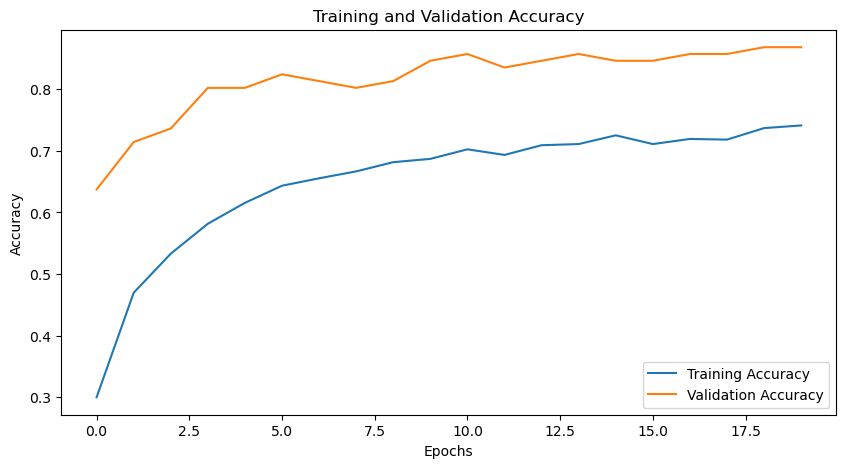

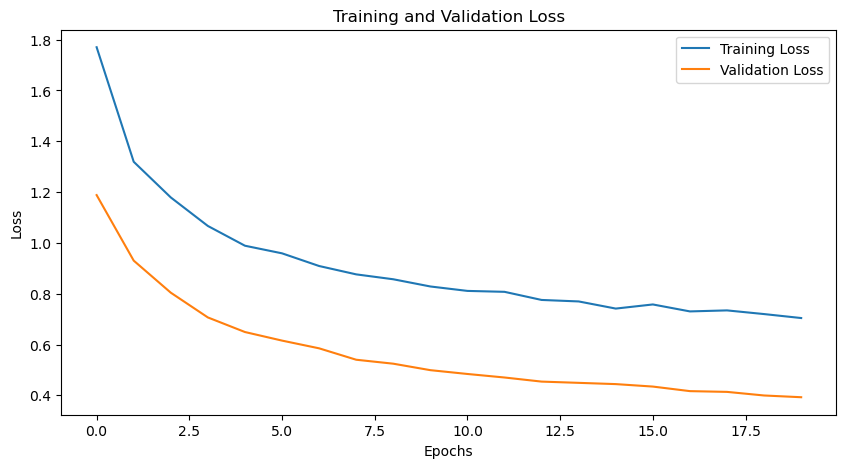

In [27]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# Save the model
model.save('nails_classifier_model.keras')  # Save as .keras format
print("Model saved as nails_classifier_model.keras")

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('nails_classifier_model.keras')
print("Model loaded successfully!")

Model saved as nails_classifier_model.keras
Model loaded successfully!


C:\Users\Aryan Gupta\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [29]:
import pickle

# Save the model using pickle
with open('nails_classifier_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved as nails_classifier_model.pkl")

# Load the model
with open('nails_classifier_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print("Model loaded successfully!")

Model saved as nails_classifier_model.pkl
Model loaded successfully!


Test the Model for Inference

In [43]:
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import requests
from io import BytesIO
from PIL import Image

# Define a function for prediction
def predict_from_url(image_url, model, class_indices):
    """
    Predict the class of an image from a URL.

    Args:
        image_url (str): The URL of the image to predict.
        model (keras.Model): The trained Keras model.
        class_indices (dict): Dictionary mapping class indices to class labels.

    Returns:
        str: Predicted class label.
        dict: Confidence scores for each class.
    """
    try:
        # Download and load the image
        response = requests.get(image_url)
        response.raise_for_status()  # Raise an error for invalid responses
        image = Image.open(BytesIO(response.content))
        image = image.resize((224, 224))  # Resize to match model input
        image_array = img_to_array(image)
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        image_array = image_array / 255.0  # Normalize

        # Predict using the model
        predictions = model.predict(image_array)
        predicted_class = np.argmax(predictions)  # Get the index of the highest probability class

        # Map the predicted class to the actual label
        reversed_class_indices = {v: k for k, v in class_indices.items()}
        predicted_label = reversed_class_indices[predicted_class]

        # Confidence scores for all classes
        confidence_scores = dict(zip(reversed_class_indices.values(), predictions[0] * 100))

        return predicted_label, confidence_scores

    except Exception as e:
        return f"Error: {str(e)}", None

In [47]:
# Example image URL
test_image_url = 'https://lh3.googleusercontent.com/proxy/OS3EGI_IVmtvw4JXla86oBfHIqwEQWc6o-qH8tRSDQzVvuFN-1uOZ4vgF2tFFYb-8l7f4ixbnQZlrX75C9X6fgoKbW5hjfgCfneiYy93ps8PHXUwmfs8UcZXXLtorGdurA'

# Call the prediction function
predicted_label, confidence_scores = predict_from_url(test_image_url, model, train_data.class_indices)

# Display results
if confidence_scores:
    print(f"Predicted Class: {predicted_label}")
    print("\nConfidence Scores:")
    for class_name, confidence in confidence_scores.items():
        print(f"{class_name}: {confidence:.2f}%")
else:
    print(predicted_label)  # Print error message if any

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Class: Onychogryphosis

Confidence Scores:
Acral_Lentiginous_Melanoma: 1.03%
Healthy_Nail: 0.34%
Onychogryphosis: 94.35%
blue_finger: 0.18%
clubbing: 1.71%
pitting: 2.39%
